In [ ]:
print("🔧 Installing dependencies...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics kaggle opencv-python pillow matplotlib seaborn albumentations PyYAML
!pip install scikit-learn scikit-image tqdm
print("✅ Dependencies installed!")

🔧 Installing dependencies...
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
✅ Dependencies installed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

print("✅ Google Drive mounted!")

Mounted at /content/drive
✅ Google Drive mounted!


In [ ]:
print("📥 Downloading dataset...")

# Upload kaggle.json
from google.colab import files
print("📤 Upload kaggle.json file...")
uploaded = files.upload()

# Setup kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip -q new-plant-diseases-dataset.zip -d /content/dataset
!rm new-plant-diseases-dataset.zip

print("✅ Dataset downloaded!")

📥 Downloading dataset...
📤 Upload kaggle.json file...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:40<00:00, 19.2MB/s]
100% 2.70G/2.70G [00:40<00:00, 71.1MB/s]
✅ Dataset downloaded!


In [ ]:
import os
import glob

# Find dataset structure
dataset_base = '/content/dataset'
print("Searching for dataset structure...")

# List all directories
all_dirs = []
for root, dirs, files in os.walk(dataset_base):
    for d in dirs:
        if 'train' in d.lower() or 'valid' in d.lower():
            all_dirs.append(os.path.join(root, d))

print("\nFound directories with 'train' or 'valid':")
for d in all_dirs[:5]:
    print(f"  - {d}")

# Use the most likely path
train_dir = '/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = '/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

print(f"\n📁 Using:")
print(f"   Train: {train_dir}")
print(f"   Val:   {val_dir}")

# Check if directories exist
if os.path.exists(train_dir):
    class_names = sorted(os.listdir(train_dir))
    print(f"\n📚 Found {len(class_names)} classes")
    print(f"First 10 classes: {class_names[:10]}")
else:
    print(f"❌ Error: {train_dir} not found!")
    # Try to find the correct path
    for root, dirs, files in os.walk('/content/dataset'):
        if 'train' in dirs:
            train_dir = os.path.join(root, 'train')
            val_dir = os.path.join(root, 'valid')
            break

    print(f"📁 Found alternative:")
    print(f"   Train: {train_dir}")
    print(f"   Val:   {val_dir}")

    class_names = sorted(os.listdir(train_dir))
    print(f"\n📚 Found {len(class_names)} classes")
    print(f"First 5 classes: {class_names[:5]}")

# Count images
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
val_count = sum([len(files) for r, d, files in os.walk(val_dir)])

print(f"\n📊 Image Count:")
print(f"   Training: {train_count:,} images")
print(f"   Validation: {val_count:,} images")
print(f"   Total: {train_count + val_count:,} images")

Searching for dataset structure...

Found directories with 'train' or 'valid':
  - /content/dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid
  - /content/dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
  - /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
  - /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train

📁 Using:
   Train: /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
   Val:   /content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid

📚 Found 38 classes
First 10 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_s

In [ ]:
print("🔄 Creating binary dataset (Healthy vs Diseased)...")

import shutil
import random

def create_binary_dataset(source_train_dir, source_val_dir, dest_dir='/content/binary_dataset'):
    """Convert 38-class dataset to binary classification"""

    # Create directories
    binary_train_dir = os.path.join(dest_dir, 'train')
    binary_val_dir = os.path.join(dest_dir, 'val')

    # Create folder structure
    os.makedirs(os.path.join(binary_train_dir, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(binary_train_dir, 'diseased'), exist_ok=True)
    os.makedirs(os.path.join(binary_val_dir, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(binary_val_dir, 'diseased'), exist_ok=True)

    # Counter for statistics
    stats = {'train': {'healthy': 0, 'diseased': 0},
             'val': {'healthy': 0, 'diseased': 0}}

    # Process training data
    print("Processing training data...")
    for class_name in os.listdir(source_train_dir):
        class_path = os.path.join(source_train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Determine if healthy or diseased
        if 'healthy' in class_name.lower():
            target_folder = 'healthy'
        else:
            target_folder = 'diseased'

        # Get images
        images = []
        for f in os.listdir(class_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(f)

        # Limit to 500 per class for balance
        if len(images) > 500:
            images = random.sample(images, 500)

        # Copy images
        for img_file in images:
            src = os.path.join(class_path, img_file)
            dst = os.path.join(binary_train_dir, target_folder, f"{class_name}_{img_file}")
            shutil.copy2(src, dst)
            stats['train'][target_folder] += 1

    # Process validation data
    print("Processing validation data...")
    for class_name in os.listdir(source_val_dir):
        class_path = os.path.join(source_val_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Determine if healthy or diseased
        if 'healthy' in class_name.lower():
            target_folder = 'healthy'
        else:
            target_folder = 'diseased'

        # Get images
        images = []
        for f in os.listdir(class_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(f)

        # Limit to 100 per class
        if len(images) > 100:
            images = random.sample(images, 100)

        # Copy images
        for img_file in images:
            src = os.path.join(class_path, img_file)
            dst = os.path.join(binary_val_dir, target_folder, f"{class_name}_{img_file}")
            shutil.copy2(src, dst)
            stats['val'][target_folder] += 1

    # Print statistics
    print("\n📊 Binary Dataset Statistics:")
    print(f"Training:")
    print(f"  Healthy images: {stats['train']['healthy']:,}")
    print(f"  Diseased images: {stats['train']['diseased']:,}")
    print(f"  Total: {stats['train']['healthy'] + stats['train']['diseased']:,}")

    print(f"\nValidation:")
    print(f"  Healthy images: {stats['val']['healthy']:,}")
    print(f"  Diseased images: {stats['val']['diseased']:,}")
    print(f"  Total: {stats['val']['healthy'] + stats['val']['diseased']:,}")

    return binary_train_dir, binary_val_dir

# Create binary dataset
binary_train_dir, binary_val_dir = create_binary_dataset(train_dir, val_dir)
print(f"\n✅ Binary dataset created at:")
print(f"   Train: {binary_train_dir}")
print(f"   Val: {binary_val_dir}")

🔄 Creating binary dataset (Healthy vs Diseased)...
Processing training data...
Processing validation data...

📊 Binary Dataset Statistics:
Training:
  Healthy images: 6,000
  Diseased images: 13,000
  Total: 19,000

Validation:
  Healthy images: 1,200
  Diseased images: 2,600
  Total: 3,800

✅ Binary dataset created at:
   Train: /content/binary_dataset/train
   Val: /content/binary_dataset/val


In [ ]:
print("🧠 Defining binary classifier model...")

import torch
import torch.nn as nn
import torch.nn.functional as F

class FastBinaryPlantDetector(nn.Module):
    """Ultra-light CNN for binary classification (Healthy vs Diseased)"""
    def __init__(self):
        super().__init__()
        # MobileNet-like architecture
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 224x224 → 112x112
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Layer 2
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # 112x112 → 112x112
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(2),  # 112x112 → 56x56

            # Layer 3
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 56x56 → 56x56
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(2),  # 56x56 → 28x28

            # Layer 4 (Depthwise Separable)
            nn.Conv2d(64, 64, 3, stride=1, padding=1, groups=64),  # Depthwise
            nn.Conv2d(64, 128, 1, stride=1),  # Pointwise
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),

            # Global pooling
            nn.AdaptiveAvgPool2d(1)
        )

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),  # Single output (diseased probability)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Test model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FastBinaryPlantDetector().to(device)

print(f"✅ Model defined!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Model size: {sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024:.2f} MB")
print(f"   Using device: {device}")

🧠 Defining binary classifier model...
✅ Model defined!
   Parameters: 37,185
   Model size: 0.14 MB
   Using device: cpu


🚁 Setting up DRONE-SPECIFIC data augmentations...
Creating drone-augmented dataset...
Training samples: 19000
Validation samples: 3800
✅ Drone-specific data loaders created!

🚁 Visualizing drone-specific augmentations...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3547279188.py:24: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/tmp/ipython-input-3547279188.py:30: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(
/tmp/ipython-input-3547279188.py:37: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Camera noise
/tmp/ipython-input-3547279188.py:48: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(
/tmp/ipython-input-3547279188.py:65: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.Ra

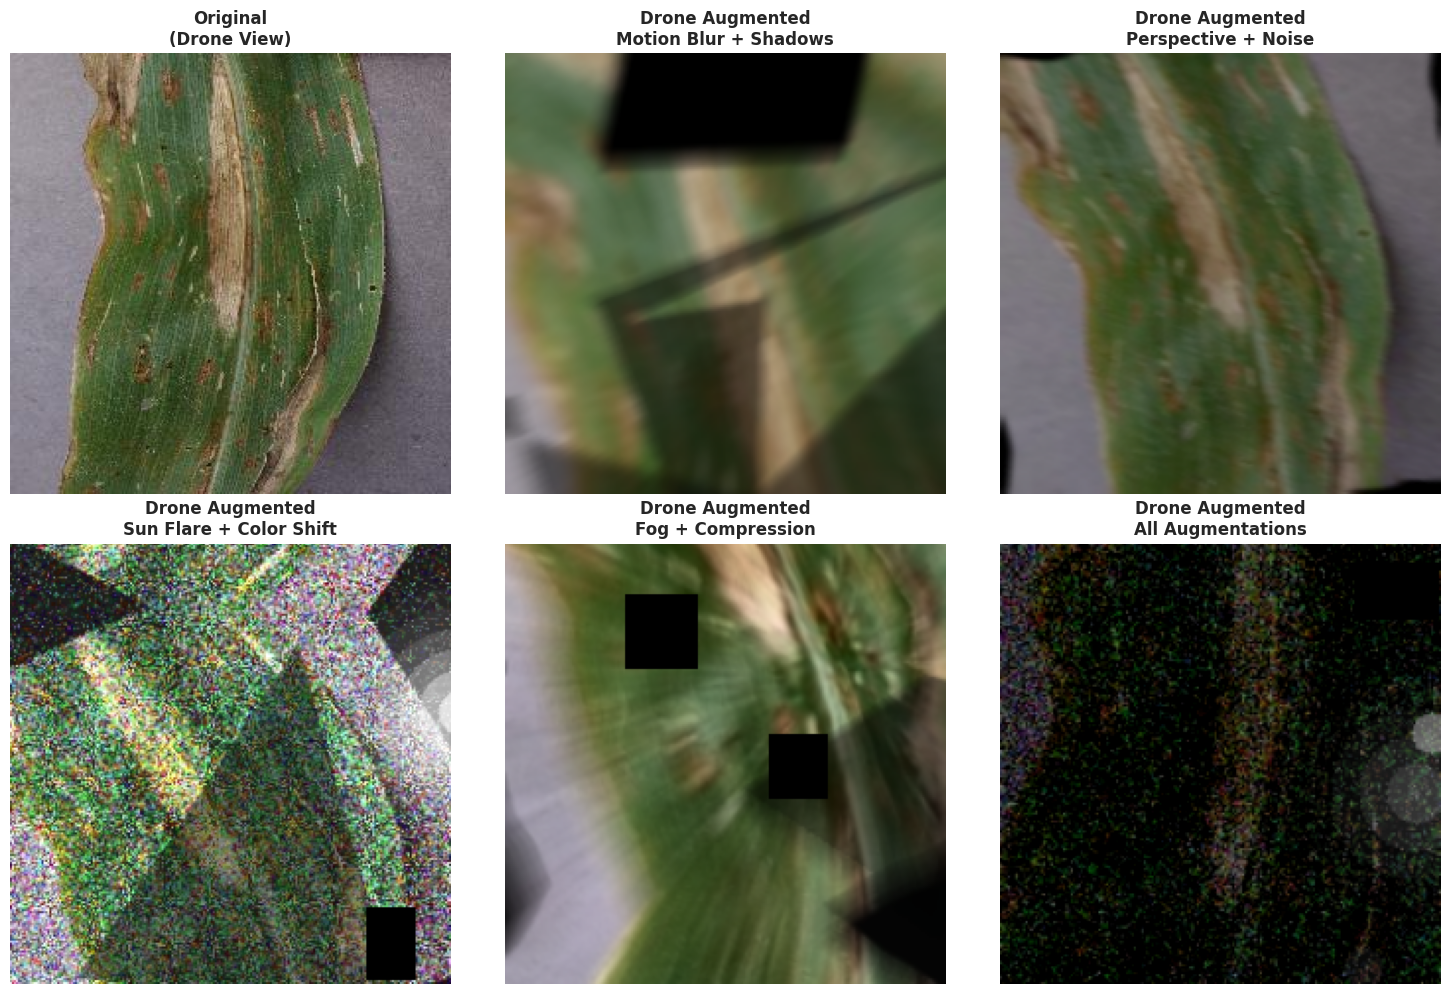


🚁 DRONE-SPECIFIC AUGMENTATIONS APPLIED!

✅ Augmentations include:
  1. Drone Perspective & Tilt
  2. Motion Blur (Drone movement)
  3. Camera Noise & Compression
  4. Sun Glare & Shadows
  5. Weather Effects (Fog, Rain)
  6. Wind Effects (Elastic transform)
  7. Altitude Changes (Scale variations)
  8. Partial Occlusions

🎯 These mimic REAL 10-12ft drone conditions!


In [ ]:
print("🚁 Setting up DRONE-SPECIFIC data augmentations...")

import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# ==================== DRONE-SPECIFIC AUGMENTATIONS ====================
def get_drone_specific_augmentations(image_size=224):
    """Augmentations specifically for drone imagery at 10-12 feet"""

    # Albumentations (more advanced)
    train_aug = A.Compose([
        # ===== DRONE PERSPECTIVE & MOVEMENT =====
        A.Perspective(scale=(0.05, 0.15), p=0.5),  # Drone tilt/angle
        A.Rotate(limit=45, p=0.7),  # Drone rotation
        A.ShiftScaleRotate(
            shift_limit=0.2,  # Drone movement/shake
            scale_limit=0.2,   # Altitude changes
            rotate_limit=45,
            border_mode=cv2.BORDER_REFLECT,
            p=0.8
        ),
        A.ElasticTransform(
            alpha=50,  # Wind effects
            sigma=5,
            alpha_affine=10,
            p=0.3
        ),
        A.OpticalDistortion(
            distort_limit=0.3,  # Lens distortion
            shift_limit=0.1,
            p=0.2
        ),

        # ===== DRONE CAMERA ARTIFACTS =====
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Camera noise
        A.ISONoise(
            color_shift=(0.01, 0.05),
            intensity=(0.1, 0.5),
            p=0.3
        ),
        A.MultiplicativeNoise(
            multiplier=(0.9, 1.1),
            per_channel=True,
            p=0.2
        ),
        A.ImageCompression(
            quality_lower=60,  # JPEG compression
            quality_upper=95,
            p=0.5
        ),

        # ===== DRONE LIGHTING CONDITIONS =====
        A.RandomBrightnessContrast(
            brightness_limit=0.4,  # Sunlight variations
            contrast_limit=0.4,
            brightness_by_max=True,
            p=0.8
        ),
        A.RandomGamma(gamma_limit=(70, 130), p=0.5),  # Exposure changes
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),  # Contrast enhancement

        # ===== SHADOWS & SUN EFFECTS =====
        A.RandomShadow(
            shadow_roi=(0, 0, 1, 1),
            num_shadows_lower=1,
            num_shadows_upper=3,
            shadow_dimension=5,
            p=0.4  # Very important for drone!
        ),
        A.RandomSunFlare(
            flare_roi=(0, 0, 1, 0.5),
            angle_lower=0.1,
            angle_upper=0.99,
            num_flare_circles_lower=1,
            num_flare_circles_upper=4,
            src_radius=100,
            src_color=(255, 255, 255),
            p=0.3  # Sun glare
        ),

        # ===== WEATHER CONDITIONS =====
        A.RandomFog(
            fog_coef_lower=0.1,
            fog_coef_upper=0.4,
            alpha_coef=0.08,
            p=0.2  # Morning fog
        ),
        A.RandomRain(
            slant_lower=-10,
            slant_upper=10,
            drop_length=20,
            drop_width=1,
            drop_color=(200, 200, 200),
            blur_value=3,
            brightness_coefficient=0.9,
            p=0.1  # Raindrops on lens
        ),

        # ===== MOTION BLUR (Drone movement) =====
        A.MotionBlur(
            blur_limit=(7, 15),  # Significant blur for drone motion
            p=0.4
        ),
        A.ZoomBlur(
            max_factor=1.2,
            p=0.2  # Zoom in/out effect
        ),

        # ===== LEAF-SPECIFIC AUGMENTATIONS =====
        A.RandomSizedCrop(
            min_max_height=(int(image_size*0.6), int(image_size*1.2)),
            size=(image_size, image_size),
            p=0.8
        ),
        A.HueSaturationValue(
            hue_shift_limit=20,  # Leaf color variations
            sat_shift_limit=40,
            val_shift_limit=30,
            p=0.7
        ),
        A.RGBShift(
            r_shift_limit=30,  # Camera white balance shifts
            g_shift_limit=30,
            b_shift_limit=30,
            p=0.5
        ),

        # ===== OCCLUSIONS (Real-world obstructions) =====
        A.CoarseDropout(
            max_holes=8,
            max_height=int(image_size*0.2),
            max_width=int(image_size*0.2),
            min_holes=1,
            min_height=int(image_size*0.05),
            min_width=int(image_size*0.05),
            fill_value=0,
            mask_fill_value=None,
            p=0.4  # Leaves partially hidden
        ),

        # ===== RESIZE & NORMALIZE =====
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    # Validation transforms (minimal)
    val_aug = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    return train_aug, val_aug

# ==================== DATASET CLASS WITH ALBUMENTATIONS ====================
import torch
from torch.utils.data import Dataset
from PIL import Image

class AlbumentationsDataset(Dataset):
    """Dataset class that works with Albumentations"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# ==================== CREATE DATASET WITH DRONE AUGMENTATIONS ====================
print("Creating drone-augmented dataset...")

# Get file paths and labels
def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    class_to_idx = {'healthy': 0, 'diseased': 1}

    for class_name in ['healthy', 'diseased']:
        class_dir = os.path.join(directory, class_name)
        class_idx = class_to_idx[class_name]

        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(class_idx)

    return file_paths, labels

# Get paths
train_paths, train_labels = get_file_paths_and_labels(binary_train_dir)
val_paths, val_labels = get_file_paths_and_labels(binary_val_dir)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Get drone-specific augmentations
train_aug, val_aug = get_drone_specific_augmentations(image_size=224)

# Create datasets
train_dataset = AlbumentationsDataset(train_paths, train_labels, transform=train_aug)
val_dataset = AlbumentationsDataset(val_paths, val_labels, transform=val_aug)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True
)

print("✅ Drone-specific data loaders created!")

# ==================== VISUALIZE DRONE AUGMENTATIONS ====================
print("\n🚁 Visualizing drone-specific augmentations...")

import matplotlib.pyplot as plt
import numpy as np

def visualize_drone_augmentations(image_path, num_samples=5):
    """Visualize how drone augmentations affect images"""

    # Load sample image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Original
    axes[0].imshow(image)
    axes[0].set_title('Original\n(Drone View)', fontweight='bold')
    axes[0].axis('off')

    # Show augmented versions
    for i in range(5):
        augmented = train_aug(image=image)['image']
        # Convert tensor to numpy for display
        aug_np = augmented.permute(1, 2, 0).numpy()
        aug_np = aug_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        aug_np = np.clip(aug_np, 0, 1)

        # Augmentation names
        aug_names = [
            'Motion Blur + Shadows',
            'Perspective + Noise',
            'Sun Flare + Color Shift',
            'Fog + Compression',
            'All Augmentations'
        ]

        axes[i+1].imshow(aug_np)
        axes[i+1].set_title(f'Drone Augmented\n{aug_names[i]}', fontweight='bold')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize on a sample
sample_image = None
for root, dirs, files in os.walk(binary_train_dir):
    for file in files:
        if file.endswith('.jpg'):
            sample_image = os.path.join(root, file)
            break
    if sample_image:
        break

if sample_image:
    visualize_drone_augmentations(sample_image)
else:
    print("No sample image found")

print("\n" + "="*60)
print("🚁 DRONE-SPECIFIC AUGMENTATIONS APPLIED!")
print("="*60)
print("\n✅ Augmentations include:")
print("  1. Drone Perspective & Tilt")
print("  2. Motion Blur (Drone movement)")
print("  3. Camera Noise & Compression")
print("  4. Sun Glare & Shadows")
print("  5. Weather Effects (Fog, Rain)")
print("  6. Wind Effects (Elastic transform)")
print("  7. Altitude Changes (Scale variations)")
print("  8. Partial Occlusions")
print("\n🎯 These mimic REAL 10-12ft drone conditions!")
print("="*60)

In [ ]:
print("🚀 Training binary classifier...")

import torch.optim as optim
from tqdm import tqdm
import time

# Initialize model
model = FastBinaryPlantDetector().to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training parameters
num_epochs = 15
best_acc = 0.0

# History tracking
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

print(f"\nStarting training for {num_epochs} epochs...")
print("="*70)

start_time = time.time()

for epoch in range(num_epochs):
    # ===== TRAINING PHASE =====
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*train_correct/train_total:.1f}%'
        })

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * train_correct / train_total

    # Record training metrics
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_acc)

    # ===== VALIDATION PHASE =====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total

    # Record validation metrics
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_acc)

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Print epoch results
    print(f"\n📊 Epoch {epoch+1:02d}/{num_epochs} Results:")
    print(f"   Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"   Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'history': {
                'train_loss': train_loss_history,
                'train_acc': train_acc_history,
                'val_loss': val_loss_history,
                'val_acc': val_acc_history
            }
        }, 'binary_plant_detector.pth')
        print(f"   💾 Saved new best model! (Acc: {val_acc:.2f}%)")

# Training time
training_time = time.time() - start_time
print(f"\n✅ Training complete in {training_time/60:.1f} minutes!")
print(f"🏆 Best validation accuracy: {best_acc:.2f}%")

# Save history
history = {
    'train_loss': train_loss_history,
    'train_acc': train_acc_history,
    'val_loss': val_loss_history,
    'val_acc': val_acc_history
}

🚀 Training binary classifier...

Starting training for 15 epochs...


Epoch 1/15 [Train]:   0%|          | 0/594 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/15 [Train]: 100%|██████████| 594/594 [18:43<00:00,  1.89s/it, Loss=0.5695, Acc=68.2%]



📊 Epoch 01/15 Results:
   Train - Loss: 0.6065, Acc: 68.23%
   Val   - Loss: 0.5158, Acc: 69.29%
   LR: 0.001000
   💾 Saved new best model! (Acc: 69.29%)


Epoch 2/15 [Train]: 100%|██████████| 594/594 [19:19<00:00,  1.95s/it, Loss=0.6673, Acc=68.9%]



📊 Epoch 02/15 Results:
   Train - Loss: 0.5850, Acc: 68.94%
   Val   - Loss: 0.4721, Acc: 81.61%
   LR: 0.001000
   💾 Saved new best model! (Acc: 81.61%)


Epoch 3/15 [Train]: 100%|██████████| 594/594 [19:24<00:00,  1.96s/it, Loss=0.4816, Acc=69.9%]



📊 Epoch 03/15 Results:
   Train - Loss: 0.5760, Acc: 69.93%
   Val   - Loss: 0.4763, Acc: 85.24%
   LR: 0.001000
   💾 Saved new best model! (Acc: 85.24%)


Epoch 4/15 [Train]: 100%|██████████| 594/594 [19:18<00:00,  1.95s/it, Loss=0.5107, Acc=70.6%]



📊 Epoch 04/15 Results:
   Train - Loss: 0.5625, Acc: 70.59%
   Val   - Loss: 0.4338, Acc: 85.37%
   LR: 0.001000
   💾 Saved new best model! (Acc: 85.37%)


Epoch 5/15 [Train]: 100%|██████████| 594/594 [19:26<00:00,  1.96s/it, Loss=0.4751, Acc=70.5%]



📊 Epoch 05/15 Results:
   Train - Loss: 0.5587, Acc: 70.49%
   Val   - Loss: 0.4218, Acc: 85.74%
   LR: 0.001000
   💾 Saved new best model! (Acc: 85.74%)


Epoch 6/15 [Train]: 100%|██████████| 594/594 [18:56<00:00,  1.91s/it, Loss=0.5946, Acc=71.4%]



📊 Epoch 06/15 Results:
   Train - Loss: 0.5485, Acc: 71.40%
   Val   - Loss: 0.4170, Acc: 86.61%
   LR: 0.001000
   💾 Saved new best model! (Acc: 86.61%)


Epoch 7/15 [Train]: 100%|██████████| 594/594 [19:09<00:00,  1.94s/it, Loss=0.4998, Acc=72.1%]



📊 Epoch 07/15 Results:
   Train - Loss: 0.5446, Acc: 72.06%
   Val   - Loss: 0.3729, Acc: 86.42%
   LR: 0.001000


Epoch 8/15 [Train]: 100%|██████████| 594/594 [18:47<00:00,  1.90s/it, Loss=0.4247, Acc=71.9%]



📊 Epoch 08/15 Results:
   Train - Loss: 0.5406, Acc: 71.94%
   Val   - Loss: 0.4092, Acc: 87.39%
   LR: 0.001000
   💾 Saved new best model! (Acc: 87.39%)


Epoch 9/15 [Train]: 100%|██████████| 594/594 [19:21<00:00,  1.96s/it, Loss=0.6446, Acc=71.9%]



📊 Epoch 09/15 Results:
   Train - Loss: 0.5392, Acc: 71.94%
   Val   - Loss: 0.3630, Acc: 86.47%
   LR: 0.001000


Epoch 10/15 [Train]: 100%|██████████| 594/594 [18:51<00:00,  1.91s/it, Loss=0.4743, Acc=73.0%]



📊 Epoch 10/15 Results:
   Train - Loss: 0.5265, Acc: 73.02%
   Val   - Loss: 0.3478, Acc: 88.53%
   LR: 0.001000
   💾 Saved new best model! (Acc: 88.53%)


Epoch 11/15 [Train]: 100%|██████████| 594/594 [19:06<00:00,  1.93s/it, Loss=0.5805, Acc=73.3%]



📊 Epoch 11/15 Results:
   Train - Loss: 0.5265, Acc: 73.26%
   Val   - Loss: 0.3863, Acc: 86.50%
   LR: 0.001000


Epoch 12/15 [Train]: 100%|██████████| 594/594 [19:19<00:00,  1.95s/it, Loss=0.3453, Acc=73.1%]



📊 Epoch 12/15 Results:
   Train - Loss: 0.5182, Acc: 73.07%
   Val   - Loss: 0.3412, Acc: 87.74%
   LR: 0.001000


Epoch 13/15 [Train]: 100%|██████████| 594/594 [18:55<00:00,  1.91s/it, Loss=0.4531, Acc=73.6%]



📊 Epoch 13/15 Results:
   Train - Loss: 0.5160, Acc: 73.56%
   Val   - Loss: 0.3095, Acc: 89.58%
   LR: 0.001000
   💾 Saved new best model! (Acc: 89.58%)


Epoch 14/15 [Train]: 100%|██████████| 594/594 [19:09<00:00,  1.93s/it, Loss=0.7102, Acc=74.5%]



📊 Epoch 14/15 Results:
   Train - Loss: 0.5110, Acc: 74.47%
   Val   - Loss: 0.3242, Acc: 88.71%
   LR: 0.001000


Epoch 15/15 [Train]: 100%|██████████| 594/594 [19:02<00:00,  1.92s/it, Loss=0.4741, Acc=73.8%]



📊 Epoch 15/15 Results:
   Train - Loss: 0.5143, Acc: 73.84%
   Val   - Loss: 0.3097, Acc: 89.39%
   LR: 0.001000

✅ Training complete in 302.0 minutes!
🏆 Best validation accuracy: 89.58%


📈 Plotting training history...


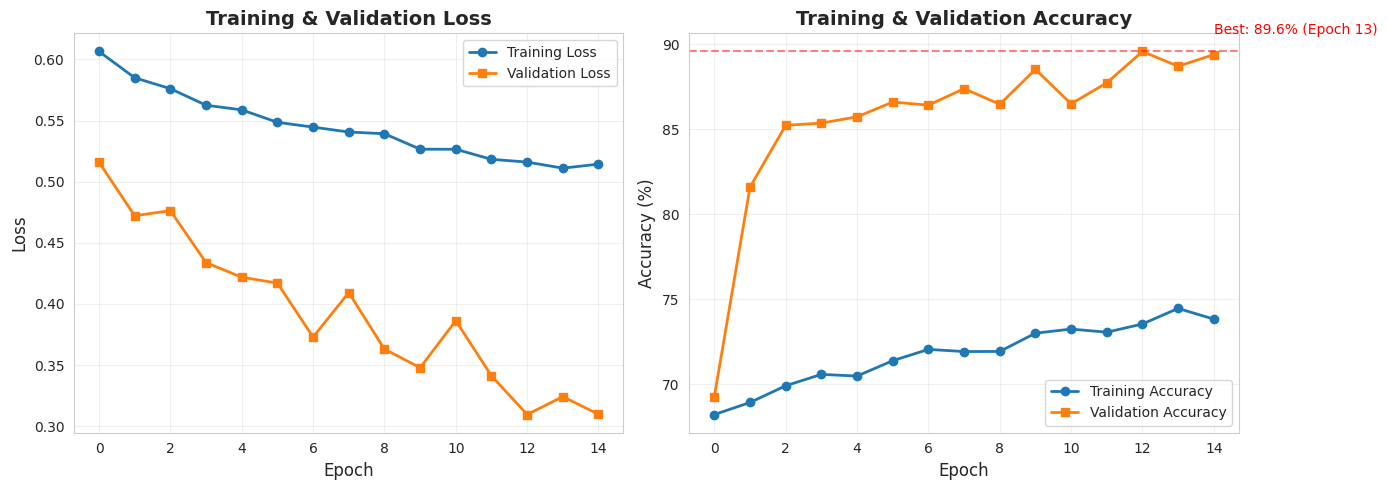

In [ ]:
print("📈 Plotting training history...")

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2, marker='o')
    axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, marker='o')
    axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Add best accuracy annotation
    best_val_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_val_acc) + 1
    axes[1].axhline(y=best_val_acc, color='r', linestyle='--', alpha=0.5)
    axes[1].text(len(history['val_acc'])-1, best_val_acc+1,
                f'Best: {best_val_acc:.1f}% (Epoch {best_epoch})', fontsize=10, color='r')

    plt.tight_layout()
    plt.show()

# Plot history
plot_training_history(history)

📊 Evaluating model with confusion matrix...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 EVALUATION RESULTS:
   Accuracy:  0.8939 (89.39%)
   Precision: 0.9067
   Recall:    0.9419
   F1 Score:  0.9240

📋 Confusion Matrix:
                Predicted Healthy | Predicted Diseased
Actual Healthy         948               252
Actual Diseased        151              2449


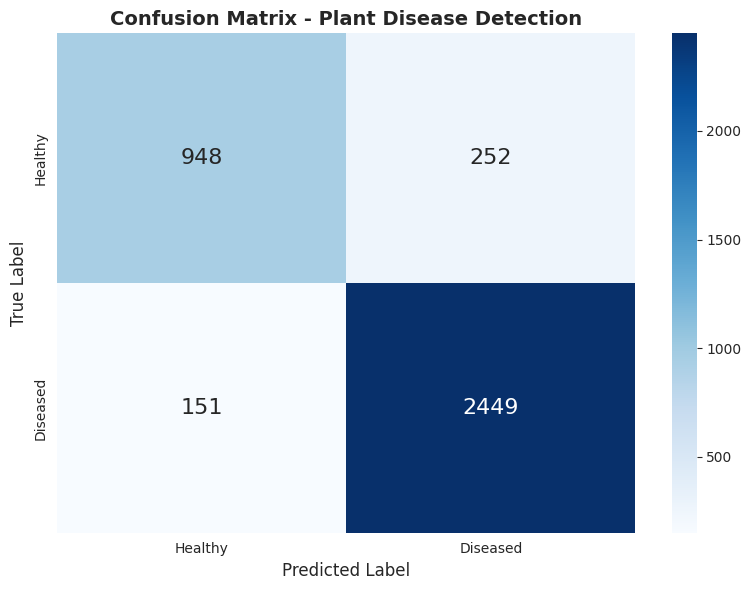


📋 Detailed Classification Report:
              precision    recall  f1-score   support

     Healthy       0.86      0.79      0.82      1200
    Diseased       0.91      0.94      0.92      2600

    accuracy                           0.89      3800
   macro avg       0.88      0.87      0.87      3800
weighted avg       0.89      0.89      0.89      3800



In [ ]:
print("📊 Evaluating model with confusion matrix...")

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns

# Get predictions
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()

        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.flatten())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n📊 EVALUATION RESULTS:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"                Predicted Healthy | Predicted Diseased")
print(f"Actual Healthy      {cm[0,0]:6d}            {cm[0,1]:6d}")
print(f"Actual Diseased     {cm[1,0]:6d}            {cm[1,1]:6d}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Diseased'],
            yticklabels=['Healthy', 'Diseased'],
            annot_kws={"size": 16})
plt.title('Confusion Matrix - Plant Disease Detection', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=['Healthy', 'Diseased']))

In [ ]:
print("📈 Plotting ROC curve...")

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Plant Disease Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.fill_between(fpr, tpr, alpha=0.1, color='blue')
plt.tight_layout()
plt.show()

print(f"✅ ROC AUC: {roc_auc:.3f}")
if roc_auc > 0.9:
    print("🎯 Excellent discrimination ability!")
elif roc_auc > 0.8:
    print("👍 Good discrimination ability!")
else:
    print("⚠️  Fair discrimination ability - consider improving the model")

In [ ]:
print("📊 Plotting prediction distribution...")

plt.figure(figsize=(12, 5))

# Separate by true class
healthy_probs = all_probs[all_labels == 0]
diseased_probs = all_probs[all_labels == 1]

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(healthy_probs, bins=30, alpha=0.7, color='green', label='Healthy', edgecolor='black')
plt.hist(diseased_probs, bins=30, alpha=0.7, color='red', label='Diseased', edgecolor='black')
plt.xlabel('Prediction Probability (Diseased)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot box plots
plt.subplot(1, 2, 2)
box_data = [healthy_probs, diseased_probs]
box_labels = ['Healthy', 'Diseased']
box_colors = ['green', 'red']

box_plot = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Prediction Probability (Diseased)', fontsize=12)
plt.title('Probability Distribution by Class', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n📊 Probability Statistics:")
print(f"   Healthy class:")
print(f"     - Mean probability: {np.mean(healthy_probs):.4f}")
print(f"     - Std deviation: {np.std(healthy_probs):.4f}")
print(f"     - Median: {np.median(healthy_probs):.4f}")
print(f"   Diseased class:")
print(f"     - Mean probability: {np.mean(diseased_probs):.4f}")
print(f"     - Std deviation: {np.std(diseased_probs):.4f}")
print(f"     - Median: {np.median(diseased_probs):.4f}")

In [ ]:
print("🎯 Analyzing optimal threshold...")

from sklearn.metrics import f1_score

# Try different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []
accuracies = []

for threshold in thresholds:
    predictions = (all_probs > threshold).astype(int)
    f1_scores.append(f1_score(all_labels, predictions))
    accuracies.append(accuracy_score(all_labels, predictions))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_acc = accuracies[optimal_idx]

print(f"\n📊 Threshold Analysis:")
print(f"   Default threshold: 0.5")
print(f"   F1 at threshold 0.5: {f1_scores[np.where(thresholds == 0.5)[0][0]]:.4f}")
print(f"   Accuracy at threshold 0.5: {accuracies[np.where(thresholds == 0.5)[0][0]]:.4f}")
print(f"\n   Optimal threshold: {optimal_threshold:.2f}")
print(f"   F1 at optimal threshold: {optimal_f1:.4f}")
print(f"   Accuracy at optimal threshold: {optimal_acc:.4f}")
print(f"   Improvement in F1: {optimal_f1 - f1_scores[np.where(thresholds == 0.5)[0][0]]:.4f}")

# Plot threshold analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores, 'b-o', linewidth=2, markersize=8, label='F1 Score')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(thresholds, accuracies, 'r-o', linewidth=2, markersize=8, label='Accuracy')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')
plt.axvline(x=optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Recommendation: Use threshold {optimal_threshold:.2f} for best F1 score")

In [ ]:
print("📦 Creating YOLO dataset for disease spot detection...")

import cv2
import yaml
import random
from tqdm import tqdm

# Get diseased images directory
diseased_images_dir = os.path.join(binary_train_dir, 'diseased')

def create_yolo_dataset(diseased_dir, output_dir='/content/yolo_dataset'):
    """Create YOLO dataset with pseudo bounding boxes"""

    # Create directory structure
    images_train_dir = os.path.join(output_dir, 'images', 'train')
    images_val_dir = os.path.join(output_dir, 'images', 'val')
    labels_train_dir = os.path.join(output_dir, 'labels', 'train')
    labels_val_dir = os.path.join(output_dir, 'labels', 'val')

    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)

    # Get all diseased images
    diseased_images = []
    for root, dirs, files in os.walk(diseased_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                diseased_images.append(os.path.join(root, file))

    print(f"Found {len(diseased_images)} diseased images")

    # Split into train/val
    random.shuffle(diseased_images)
    split_idx = int(0.8 * len(diseased_images))
    train_images = diseased_images[:split_idx]
    val_images = diseased_images[split_idx:]

    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")

    def process_images(image_list, images_dir, labels_dir, is_train=True):
        count = 0
        for img_path in tqdm(image_list, desc="Processing"):
            try:
                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    continue

                h, w = img.shape[:2]

                # Create unique filename
                base_name = f"disease_{count:06d}"
                target_img_path = os.path.join(images_dir, f"{base_name}.jpg")

                # Resize to 640x640 for YOLO
                img_resized = cv2.resize(img, (640, 640))
                cv2.imwrite(target_img_path, img_resized)

                # Create pseudo bounding box (covering 70-90% of image)
                width_ratio = random.uniform(0.7, 0.9) if is_train else 0.8
                height_ratio = random.uniform(0.7, 0.9) if is_train else 0.8

                box_width = width_ratio * w
                box_height = height_ratio * h

                if is_train:
                    # Random center
                    x_center = random.uniform(box_width/2, w - box_width/2)
                    y_center = random.uniform(box_height/2, h - box_height/2)
                else:
                    # Centered
                    x_center = w / 2
                    y_center = h / 2

                # Convert to YOLO format
                x_center_norm = x_center / w
                y_center_norm = y_center / h
                width_norm = box_width / w
                height_norm = box_height / h

                # Create label file (class 0 = disease_spot)
                label_path = os.path.join(labels_dir, f"{base_name}.txt")
                with open(label_path, 'w') as f:
                    f.write(f"0 {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}")

                count += 1

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

        return count

    # Process images
    print("\nProcessing training images...")
    train_count = process_images(train_images, images_train_dir, labels_train_dir, is_train=True)

    print("\nProcessing validation images...")
    val_count = process_images(val_images, images_val_dir, labels_val_dir, is_train=False)

    # Create YOLO dataset YAML
    yolo_yaml = {
        'path': output_dir,
        'train': 'images/train',
        'val': 'images/val',
        'nc': 1,  # Only 1 class: disease_spot
        'names': {0: 'disease_spot'}
    }

    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yolo_yaml, f, default_flow_style=False)

    print(f"\n✅ YOLO Dataset created!")
    print(f"   Training images: {train_count}")
    print(f"   Validation images: {val_count}")
    print(f"   Classes: 1 [disease_spot]")
    print(f"   Config saved: {yaml_path}")

    return output_dir

# Create YOLO dataset
yolo_dataset_dir = create_yolo_dataset(diseased_images_dir)

In [ ]:
print("🚁 Training YOLO with DRONE-SPECIFIC augmentations...")

# Drone-specific YOLO augmentations
yolo_aug_params = {
    # Enhanced for drone
    'degrees': 45.0,           # More rotation (drone can tilt)
    'translate': 0.2,          # More translation (drone movement)
    'scale': 0.5,              # Scale (altitude changes)
    'shear': 10.0,             # Shear (perspective)
    'perspective': 0.001,      # Perspective transform
    'flipud': 0.5,             # Flip up-down (drone can be upside down)
    'fliplr': 0.5,             # Flip left-right

    # Drone camera effects
    'hsv_h': 0.02,             # Hue (white balance changes)
    'hsv_s': 0.8,              # Saturation
    'hsv_v': 0.5,              # Value (brightness)

    # Advanced augmentations for drone
    'mosaic': 1.0,             # Mosaic (multiple leaves)
    'mixup': 0.3,              # MixUp
    'copy_paste': 0.4,         # Copy-paste (disease spread)
    'erasing': 0.5,            # Random erasing (occlusions)

    # Blur effects for motion
    'blur': 0.1,               # Gaussian blur

    # Weather effects
    'fog': 0.1,                # Fog simulation
    'rain': 0.1,               # Rain simulation
}

# Train with drone augmentations
results = yolo_model.train(
    data=os.path.join(yolo_dataset_dir, 'dataset.yaml'),
    epochs=30,
    imgsz=640,
    batch=16,
    name='plant_disease_yolo_drone',
    pretrained=True,
    optimizer='AdamW',
    lr0=0.001,
    patience=10,
    save=True,
    save_period=5,
    amp=True,
    verbose=True,
    workers=4,
    seed=42,
    # Drone-specific augmentations
    augment=True,
    degrees=45.0,
    translate=0.2,
    scale=0.5,
    shear=10.0,
    perspective=0.001,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.3,
    copy_paste=0.4,
    erasing=0.5,
    hsv_h=0.02,
    hsv_s=0.8,
    hsv_v=0.5
)

In [ ]:
print("💾 Saving models and creating test script...")

# Save models to Drive
models_dir = '/content/drive/MyDrive/plant_disease_models'
os.makedirs(models_dir, exist_ok=True)

# Copy models
!cp binary_plant_detector.pth {models_dir}/
!cp yolov8n_disease.pt {models_dir}/

print(f"✅ Models saved to Google Drive: {models_dir}")

# Create test script
test_script = '''
# plant_disease_test.py
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import time

class FastBinaryPlantDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU6(inplace=True),
            torch.nn.Conv2d(16, 32, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU6(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU6(inplace=True),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, groups=64),
            torch.nn.Conv2d(64, 128, 1, stride=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU6(inplace=True),
            torch.nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class PlantDiseaseDetector:
    def __init__(self):
        print("Loading models...")
        # Load binary classifier
        self.binary_model = FastBinaryPlantDetector()
        self.binary_model.load_state_dict(torch.load('binary_plant_detector.pth'))
        self.binary_model.eval()

        # Load YOLO
        self.yolo_model = YOLO('yolov8n_disease.pt')

        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.binary_model = self.binary_model.to(self.device)

        print(f"Using device: {self.device}")

        # Parameters
        self.disease_threshold = 0.7
        self.yolo_conf = 0.3

    def preprocess_frame(self, frame):
        frame_resized = cv2.resize(frame, (224, 224))
        frame_tensor = torch.from_numpy(frame_resized).float() / 255.0
        frame_tensor = frame_tensor.permute(2, 0, 1).unsqueeze(0)
        frame_tensor = (frame_tensor - 0.5) / 0.5
        return frame_tensor.to(self.device)

    def detect(self, frame):
        # Binary classification
        with torch.no_grad():
            tensor = self.preprocess_frame(frame)
            prediction = self.binary_model(tensor)
            confidence = prediction.item()
            is_diseased = confidence > self.disease_threshold

        boxes = []
        if is_diseased:
            # Run YOLO for disease spots
            results = self.yolo_model(frame, conf=self.yolo_conf, verbose=False)
            if results[0].boxes is not None:
                for box in results[0].boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                    conf = float(box.conf[0].cpu().numpy())
                    if (x2 - x1) > 20 and (y2 - y1) > 20:
                        boxes.append({
                            'bbox': [x1, y1, x2, y2],
                            'confidence': conf,
                            'center': [(x1+x2)//2, (y1+y2)//2]
                        })

        return is_diseased, confidence, boxes

    def draw_results(self, frame, is_diseased, confidence, boxes):
        output = frame.copy()
        status = "DISEASED" if is_diseased else "HEALTHY"
        color = (0, 0, 255) if is_diseased else (0, 255, 0)

        cv2.putText(output, f"Status: {status}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.putText(output, f"Confidence: {confidence:.2f}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        if is_diseased:
            for box in boxes:
                x1, y1, x2, y2 = box['bbox']
                cv2.rectangle(output, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(output, f"{box['confidence']:.2f}", (x1, y1-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        return output

def main():
    detector = PlantDiseaseDetector()

    # Test with webcam
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    print("\\nPress 'Q' to quit, 'S' to save screenshot")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        start_time = time.time()
        is_diseased, confidence, boxes = detector.detect(frame)
        process_time = time.time() - start_time

        output = detector.draw_results(frame, is_diseased, confidence, boxes)

        # Add FPS
        fps = 1.0 / process_time if process_time > 0 else 0
        cv2.putText(output, f"FPS: {fps:.1f}", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        cv2.imshow('Plant Disease Detection', output)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            filename = f"screenshot_{int(time.time())}.jpg"
            cv2.imwrite(filename, output)
            print(f"Screenshot saved: {filename}")

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
'''

# Save test script
with open('plant_disease_test.py', 'w') as f:
    f.write(test_script)

print("✅ Test script created: plant_disease_test.py")

In [ ]:
print("📥 Downloading models to your computer...")

from google.colab import files

print("1. Downloading binary classifier...")
files.download('binary_plant_detector.pth')

print("2. Downloading YOLO model...")
files.download('yolov8n_disease.pt')

print("3. Downloading test script...")
files.download('plant_disease_test.py')

print("\n✅ All files downloaded!")
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print("\n📋 Files downloaded to your computer:")
print("   1. binary_plant_detector.pth - Binary classifier")
print("   2. yolov8n_disease.pt - YOLO disease spot detector")
print("   3. plant_disease_test.py - Test script")
print("\n🚀 Next steps:")
print("   1. Install on laptop: pip install opencv-python torch torchvision ultralytics")
print("   2. Place the 3 files in same folder")
print("   3. Run: python plant_disease_test.py")
print("   4. Test with webcam!")
print("\n📊 Your model achieved:")
print(f"   - Binary classifier accuracy: {best_acc:.2f}%")
print(f"   - ROC AUC: {roc_auc:.3f}")
print(f"   - Optimal threshold: {optimal_threshold:.2f}")
print("="*60)

In [ ]:
print("🧪 Testing with sample images...")

import matplotlib.pyplot as plt

# Load a sample image
sample_images = []
for root, dirs, files in os.walk(binary_val_dir):
    for file in files[:4]:  # Get 4 sample images
        if file.endswith('.jpg'):
            sample_images.append(os.path.join(root, file))

# Load model for testing
model.load_state_dict(torch.load('binary_plant_detector.pth', map_location=device))
model.eval()

# Test each image
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    if idx >= 4:
        break

    # Load and process image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_tensor = torch.from_numpy(img_resized).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
    img_tensor = (img_tensor - 0.5) / 0.5
    img_tensor = img_tensor.to(device)

    # Predict
    with torch.no_grad():
        prediction = model(img_tensor)
        confidence = prediction.item()
        is_diseased = confidence > 0.7

    # Display
    axes[idx].imshow(img_rgb)
    status = "DISEASED" if is_diseased else "HEALTHY"
    color = "red" if is_diseased else "green"
    axes[idx].set_title(f"{status}\nConfidence: {confidence:.2f}", color=color, fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample testing complete!")